🧠 Hyperparameter Tuning for MLP
Date: May 21, 2025

🎯 Goal
Identify the optimal configuration of hyperparameters for a Multi-Layer Perceptron (MLP) model, including:

hidden_dim: number of hidden units

learning_rate: optimizer step size

batch_size: number of samples per training step

activation_fn: activation function

optimizer: optimization algorithm

⚙️ General Settings
epochs = 100

output_dim = 1

n_runs = 30 (random seeds for reproducibility)

📌 Tuned Parameters
Hidden Dimensions: [64, 128]

Learning Rate: [0.007, 0.008, 0.009, 0.01]

Batch Size: [16, 32, 64]

Activation Functions: [nn.Tanh]
(can be extended to [nn.ReLU, nn.LeakyReLU, nn.Tanh])

Optimizers: ["Adam"]
(optionally expandable to ["Adam", "AdamW", "SGD", "RMSprop"])

📊 Training Procedure
Each configuration is trained using 5-fold cross-validation

Early stopping is applied with patience = 100

Metrics are calculated on each fold and averaged:

R² (coefficient of determination)

MAE (mean absolute error)

MSE (mean squared error)

💾 Outputs Saved
Model weights

Configuration files

Evaluation metrics per run

Global experiment log (experiments_log.csv)

Training visualizations (loss_plot.png)

🏁 Final Results
Table of stable configurations (R² ≥ 95% of the best score)

Visual analysis of hyperparameter impact (boxplots per parameter)

Best configuration is highlighted separately

In [48]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [49]:
# ➤ Paths for hyperparameter search: tuning runs, logs, results

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_train.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

os.makedirs(TUNING_DIR, exist_ok=True)

# ➤ Function to create a run-specific directory
def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, activation_fn=None, optimizer_name=None, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    # 👇 Добавим активацию в имя, если она передана
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    # 👇 Добавим имя оптимизатора в имя, если оно передано
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

🛠 Device: cpu


In [50]:
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [51]:
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [52]:
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [53]:
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam"):

    # ----------------------------
    # Ensure CSV file exists and has header
    # ----------------------------
    if not os.path.exists(LOG_CSV_PATH):
        with open(LOG_CSV_PATH, "w") as f:
            f.write("run_id,hidden_dim,lr,batch_size,activation_fn,optimizer_name,R2,MAE,MSE\n")


    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔍 Проверка первых строк X и y
    print("📄 Features (X):")
    display(X.head())

    print("\n🎯 Target (y):")
    display(y.head())

    # 📐 Размерности
    print(f"\n✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")


    # ----------------------------
    # K-Fold Cross-Validation
    # ----------------------------
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold + 1} / 5")

        # 📊 Разделение данных
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 🔁 Преобразуем в тензоры
        X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        X_val = torch.tensor(X_val.values, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        y_val = torch.tensor(y_val.values, dtype=torch.float32).to(device)

        # 🧠 Создание новой модели на каждый фолд
        model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)

         # ----------------------------
        # Training loop
        # ----------------------------
        criterion = nn.MSELoss()
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        train_loss_history = []

        # 🔁 Early Stopping init
        early_stopping_patience = 20
        best_loss = float("inf")
        patience_counter = 0

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            current_loss = loss.item()
            train_loss_history.append(loss.item())

            if (epoch + 1) % 10 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}"
                print(log_str)

            # 💡 Early Stopping check
                if current_loss < best_loss:
                    best_loss = current_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print(f"⏹️ Early stopping at epoch {epoch+1} — no improvement in {early_stopping_patience} epochs.")
                        break

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            metrics = evaluate_regression(y_val, y_pred)
            fold_metrics.append(metrics)
            print(f"📈 Fold {fold + 1} metrics: {metrics}")

    # ----------------------------
    # Average metrics across folds
    # ----------------------------
    avg_metrics = {
        "MSE": sum(m["MSE"] for m in fold_metrics) / len(fold_metrics),
        "MAE": sum(m["MAE"] for m in fold_metrics) / len(fold_metrics),
        "R2":  sum(m["R2"]  for m in fold_metrics) / len(fold_metrics),
    }
    
    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "activation_fn": activation_fn.__name__,
        "optimizer_name": optimizer_name,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['Mean']
    }
    config_filename = f"config_{run_id}_ex.json"
    with open(os.path.join(run_dir, config_filename), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{batch_size},{activation_fn.__name__},{optimizer_name},{avg_metrics['R2']:.4f},{avg_metrics['MAE']:.4f},{avg_metrics['MSE']:.6f}\n")

    print(f"\n📊 Average metrics across 5 folds:\n{avg_metrics}")
    return run_id, avg_metrics
    



In [ ]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
# hidden_dim_choices = [64, 128, 256]
hidden_dim_choices = [32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 384]

# lr_choices = [0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012, 0.013, 0.014]
lr_choices = [round(lr, 5) for lr in np.arange(0.001, 0.021, 0.001)]

# batch_size_choices = [16, 32, 64]
batch_size_choices = [8, 16, 32, 48, 64, 96, 128]
activation_choices = [nn.Tanh]
# activation_choices = [nn.ReLU, nn.LeakyReLU, nn.Tanh]
optimizer_choices = ["Adam"]
# optimizer_choices = ["Adam", "AdamW"]


#hidden_dim_choices = [128, 264]
#lr_choices = [ 1e-3, 5e-3]

# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 2 # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)
    activation_fn=random.choice(activation_choices)
    optimizer_name = random.choice(optimizer_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}, batch size: {batch_size}, activation_fn: {activation_fn.__name__}, optimizer_name: {optimizer_name}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )


🔁 Run 1/2
→ hidden_dim: 128, lr: 0.00900, batch size: 16, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):


,X_int,Y_int,X_fac,Y_fac,Ang
0,8,6,4,5,20
1,5,3,3,4,10
2,1,5,17,8,150
3,4,6,19,8,10
4,7,3,21,1,60



🎯 Target (y):


,StdDev
0,0.166314
1,0.167147
2,0.171097
3,0.166579
4,0.267192



✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5


Epochs:  12%|█▏        | 12/100 [00:00<00:06, 13.28it/s]

Epoch [10/100], Loss: 0.5540


Epochs:  22%|██▏       | 22/100 [00:01<00:05, 13.10it/s]

Epoch [20/100], Loss: 0.0184


Epochs:  32%|███▏      | 32/100 [00:02<00:05, 13.00it/s]

Epoch [30/100], Loss: 0.0589


Epochs:  42%|████▏     | 42/100 [00:03<00:04, 12.94it/s]

Epoch [40/100], Loss: 0.0236


Epochs:  52%|█████▏    | 52/100 [00:03<00:03, 14.00it/s]

Epoch [50/100], Loss: 0.0090


Epochs:  62%|██████▏   | 62/100 [00:04<00:02, 13.91it/s]

Epoch [60/100], Loss: 0.0090


Epochs:  72%|███████▏  | 72/100 [00:05<00:02, 13.10it/s]

Epoch [70/100], Loss: 0.0072


Epochs:  82%|████████▏ | 82/100 [00:06<00:01, 13.02it/s]

Epoch [80/100], Loss: 0.0065


Epochs:  92%|█████████▏| 92/100 [00:06<00:00, 12.94it/s]

Epoch [90/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


Epoch [100/100], Loss: 0.0064
📈 Fold 1 metrics: {'MSE': 0.006452155765146017, 'MAE': 0.06351377069950104, 'R2': 0.07511883974075317}

🔁 Fold 2 / 5


Epochs:  12%|█▏        | 12/100 [00:00<00:07, 12.33it/s]

Epoch [10/100], Loss: 0.7638


Epochs:  22%|██▏       | 22/100 [00:01<00:06, 12.46it/s]

Epoch [20/100], Loss: 0.0841


Epochs:  32%|███▏      | 32/100 [00:02<00:05, 12.31it/s]

Epoch [30/100], Loss: 0.0223


Epochs:  40%|████      | 40/100 [00:03<00:05, 10.07it/s]

Epoch [40/100], Loss: 0.0367


Epochs:  51%|█████     | 51/100 [00:04<00:05,  8.55it/s]

Epoch [50/100], Loss: 0.0071


Epochs:  61%|██████    | 61/100 [00:05<00:05,  7.69it/s]

Epoch [60/100], Loss: 0.0104


Epochs:  71%|███████   | 71/100 [00:07<00:03,  7.65it/s]

Epoch [70/100], Loss: 0.0065


Epochs:  81%|████████  | 81/100 [00:08<00:02,  7.61it/s]

Epoch [80/100], Loss: 0.0067


Epochs:  91%|█████████ | 91/100 [00:09<00:01,  8.47it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


Epoch [100/100], Loss: 0.0062
📈 Fold 2 metrics: {'MSE': 0.006220802199095488, 'MAE': 0.0617888905107975, 'R2': 0.10539442300796509}

🔁 Fold 3 / 5


Epochs:  11%|█         | 11/100 [00:01<00:10,  8.13it/s]

Epoch [10/100], Loss: 0.8254


Epochs:  21%|██        | 21/100 [00:02<00:09,  8.61it/s]

Epoch [20/100], Loss: 0.0337


Epochs:  31%|███       | 31/100 [00:03<00:09,  6.97it/s]

Epoch [30/100], Loss: 0.0423


Epochs:  41%|████      | 41/100 [00:05<00:07,  8.14it/s]

Epoch [40/100], Loss: 0.0304


Epochs:  51%|█████     | 51/100 [00:06<00:05,  8.26it/s]

Epoch [50/100], Loss: 0.0082


Epochs:  61%|██████    | 61/100 [00:07<00:04,  8.60it/s]

Epoch [60/100], Loss: 0.0090


Epochs:  71%|███████   | 71/100 [00:08<00:03,  7.87it/s]

Epoch [70/100], Loss: 0.0075


Epochs:  81%|████████  | 81/100 [00:10<00:02,  8.29it/s]

Epoch [80/100], Loss: 0.0064


Epochs:  91%|█████████ | 91/100 [00:11<00:01,  8.69it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch [100/100], Loss: 0.0064
📈 Fold 3 metrics: {'MSE': 0.0064265551045536995, 'MAE': 0.06034469231963158, 'R2': 0.0837317705154419}

🔁 Fold 4 / 5


Epochs:  11%|█         | 11/100 [00:01<00:10,  8.85it/s]

Epoch [10/100], Loss: 0.7125


Epochs:  21%|██        | 21/100 [00:02<00:09,  8.68it/s]

Epoch [20/100], Loss: 0.1755


Epochs:  31%|███       | 31/100 [00:03<00:07,  8.76it/s]

Epoch [30/100], Loss: 0.0119


Epochs:  41%|████      | 41/100 [00:04<00:06,  8.61it/s]

Epoch [40/100], Loss: 0.0189


Epochs:  51%|█████     | 51/100 [00:05<00:05,  8.97it/s]

Epoch [50/100], Loss: 0.0176


Epochs:  61%|██████    | 61/100 [00:07<00:04,  8.70it/s]

Epoch [60/100], Loss: 0.0065


Epochs:  71%|███████   | 71/100 [00:08<00:03,  8.73it/s]

Epoch [70/100], Loss: 0.0079


Epochs:  81%|████████  | 81/100 [00:09<00:02,  8.46it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  91%|█████████ | 91/100 [00:10<00:01,  8.64it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


Epoch [100/100], Loss: 0.0062
📈 Fold 4 metrics: {'MSE': 0.006088986527174711, 'MAE': 0.06142287701368332, 'R2': 0.10518527030944824}

🔁 Fold 5 / 5


Epochs:  11%|█         | 11/100 [00:01<00:10,  8.64it/s]

Epoch [10/100], Loss: 0.7107


Epochs:  21%|██        | 21/100 [00:02<00:11,  7.11it/s]

Epoch [20/100], Loss: 0.1561


Epochs:  31%|███       | 31/100 [00:03<00:09,  7.24it/s]

Epoch [30/100], Loss: 0.0086


Epochs:  41%|████      | 41/100 [00:05<00:09,  6.14it/s]

Epoch [40/100], Loss: 0.0245


Epochs:  51%|█████     | 51/100 [00:06<00:06,  7.16it/s]

Epoch [50/100], Loss: 0.0144


Epochs:  61%|██████    | 61/100 [00:08<00:05,  7.05it/s]

Epoch [60/100], Loss: 0.0072


Epochs:  71%|███████   | 71/100 [00:09<00:03,  7.62it/s]

Epoch [70/100], Loss: 0.0076


Epochs:  81%|████████  | 81/100 [00:10<00:02,  8.76it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  91%|█████████ | 91/100 [00:12<00:01,  8.53it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


Epoch [100/100], Loss: 0.0063
📈 Fold 5 metrics: {'MSE': 0.006219390779733658, 'MAE': 0.0593307688832283, 'R2': 0.09384149312973022}
📂 Created run directory: /mnt/d/projects/wind_fluctuation_prediction_2025/experiments/tuning_mlp/mlp_128h_9e-03lr_16bs_100ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.006281578075140714, 'MAE': 0.06128019988536835, 'R2': 0.09265435934066772}

🔁 Run 2/2
→ hidden_dim: 256, lr: 0.01100, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):


,X_int,Y_int,X_fac,Y_fac,Ang
0,8,6,4,5,20
1,5,3,3,4,10
2,1,5,17,8,150
3,4,6,19,8,10
4,7,3,21,1,60



🎯 Target (y):


,StdDev
0,0.166314
1,0.167147
2,0.171097
3,0.166579
4,0.267192



✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5


Epochs:  10%|█         | 10/100 [00:03<00:30,  2.96it/s]

Epoch [10/100], Loss: 1.0443


Epochs:  20%|██        | 20/100 [00:07<00:27,  2.94it/s]

Epoch [20/100], Loss: 0.1263


Epochs:  30%|███       | 30/100 [00:10<00:23,  2.95it/s]

Epoch [30/100], Loss: 0.0489


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.08it/s]

Epoch [40/100], Loss: 0.0093


Epochs:  50%|█████     | 50/100 [00:17<00:18,  2.73it/s]

Epoch [50/100], Loss: 0.0110


Epochs:  60%|██████    | 60/100 [00:20<00:13,  2.88it/s]

Epoch [60/100], Loss: 0.0076


Epochs:  70%|███████   | 70/100 [00:24<00:10,  2.88it/s]

Epoch [70/100], Loss: 0.0066


Epochs:  80%|████████  | 80/100 [00:27<00:07,  2.73it/s]

Epoch [80/100], Loss: 0.0065


Epochs:  90%|█████████ | 90/100 [00:31<00:03,  2.98it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


Epoch [100/100], Loss: 0.0062
📈 Fold 1 metrics: {'MSE': 0.006294847931712866, 'MAE': 0.05997052788734436, 'R2': 0.0976681113243103}

🔁 Fold 2 / 5


Epochs:  10%|█         | 10/100 [00:03<00:29,  3.09it/s]

Epoch [10/100], Loss: 0.4708


Epochs:  20%|██        | 20/100 [00:06<00:27,  2.91it/s]

Epoch [20/100], Loss: 0.0626


Epochs:  30%|███       | 30/100 [00:10<00:24,  2.90it/s]

Epoch [30/100], Loss: 0.0513


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.01it/s]

Epoch [40/100], Loss: 0.0291


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.13it/s]

Epoch [50/100], Loss: 0.0141


Epochs:  60%|██████    | 60/100 [00:19<00:12,  3.17it/s]

Epoch [60/100], Loss: 0.0096


Epochs:  70%|███████   | 70/100 [00:23<00:11,  2.56it/s]

Epoch [70/100], Loss: 0.0075


Epochs:  80%|████████  | 80/100 [00:27<00:07,  2.61it/s]

Epoch [80/100], Loss: 0.0067


Epochs:  90%|█████████ | 90/100 [00:30<00:03,  3.18it/s]

Epoch [90/100], Loss: 0.0065


Epochs: 100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


Epoch [100/100], Loss: 0.0065
📈 Fold 2 metrics: {'MSE': 0.006461546290665865, 'MAE': 0.060765497386455536, 'R2': 0.07077330350875854}

🔁 Fold 3 / 5


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.15it/s]

Epoch [10/100], Loss: 0.7834


Epochs:  20%|██        | 20/100 [00:06<00:26,  3.00it/s]

Epoch [20/100], Loss: 0.0973


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.17it/s]

Epoch [30/100], Loss: 0.0303


Epochs:  40%|████      | 40/100 [00:13<00:19,  3.08it/s]

Epoch [40/100], Loss: 0.0087


Epochs:  50%|█████     | 50/100 [00:16<00:15,  3.23it/s]

Epoch [50/100], Loss: 0.0112


Epochs:  60%|██████    | 60/100 [00:19<00:13,  2.92it/s]

Epoch [60/100], Loss: 0.0071


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.06it/s]

Epoch [70/100], Loss: 0.0068


Epochs:  80%|████████  | 80/100 [00:26<00:06,  3.12it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.11it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Epoch [100/100], Loss: 0.0063
📈 Fold 3 metrics: {'MSE': 0.0063993544317781925, 'MAE': 0.061633795499801636, 'R2': 0.08760988712310791}

🔁 Fold 4 / 5


Epochs:  10%|█         | 10/100 [00:03<00:34,  2.60it/s]

Epoch [10/100], Loss: 0.0648


Epochs:  20%|██        | 20/100 [00:07<00:26,  3.02it/s]

Epoch [20/100], Loss: 0.0203


Epochs:  30%|███       | 30/100 [00:10<00:21,  3.29it/s]

Epoch [30/100], Loss: 0.0157


Epochs:  40%|████      | 40/100 [00:13<00:20,  2.95it/s]

Epoch [40/100], Loss: 0.0089


Epochs:  50%|█████     | 50/100 [00:17<00:15,  3.18it/s]

Epoch [50/100], Loss: 0.0078


Epochs:  60%|██████    | 60/100 [00:20<00:14,  2.77it/s]

Epoch [60/100], Loss: 0.0068


Epochs:  70%|███████   | 70/100 [00:24<00:09,  3.02it/s]

Epoch [70/100], Loss: 0.0064


Epochs:  80%|████████  | 80/100 [00:27<00:06,  3.16it/s]

Epoch [80/100], Loss: 0.0062


Epochs:  90%|█████████ | 90/100 [00:30<00:03,  3.24it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


Epoch [100/100], Loss: 0.0061
📈 Fold 4 metrics: {'MSE': 0.005967882461845875, 'MAE': 0.05940442904829979, 'R2': 0.12298226356506348}

🔁 Fold 5 / 5


Epochs:  10%|█         | 10/100 [00:03<00:28,  3.14it/s]

Epoch [10/100], Loss: 0.7838


Epochs:  20%|██        | 20/100 [00:06<00:26,  3.00it/s]

Epoch [20/100], Loss: 0.1217


Epochs:  30%|███       | 30/100 [00:09<00:22,  3.13it/s]

Epoch [30/100], Loss: 0.0295


Epochs:  40%|████      | 40/100 [00:13<00:22,  2.72it/s]

Epoch [40/100], Loss: 0.0112


Epochs:  50%|█████     | 50/100 [00:16<00:16,  3.12it/s]

Epoch [50/100], Loss: 0.0072


Epochs:  60%|██████    | 60/100 [00:20<00:13,  3.03it/s]

Epoch [60/100], Loss: 0.0073


Epochs:  70%|███████   | 70/100 [00:23<00:09,  3.19it/s]

Epoch [70/100], Loss: 0.0068


Epochs:  80%|████████  | 80/100 [00:26<00:07,  2.81it/s]

Epoch [80/100], Loss: 0.0064


Epochs:  90%|█████████ | 90/100 [00:29<00:03,  3.26it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]

Epoch [100/100], Loss: 0.0062
📈 Fold 5 metrics: {'MSE': 0.006136191543191671, 'MAE': 0.060697685927152634, 'R2': 0.10596358776092529}
📂 Created run directory: /mnt/d/projects/wind_fluctuation_prediction_2025/experiments/tuning_mlp/mlp_256h_1e-02lr_32bs_100ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.006251964531838894, 'MAE': 0.06049438714981079, 'R2': 0.0969994306564331}


/tmp/ipykernel_27605/1365461160.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


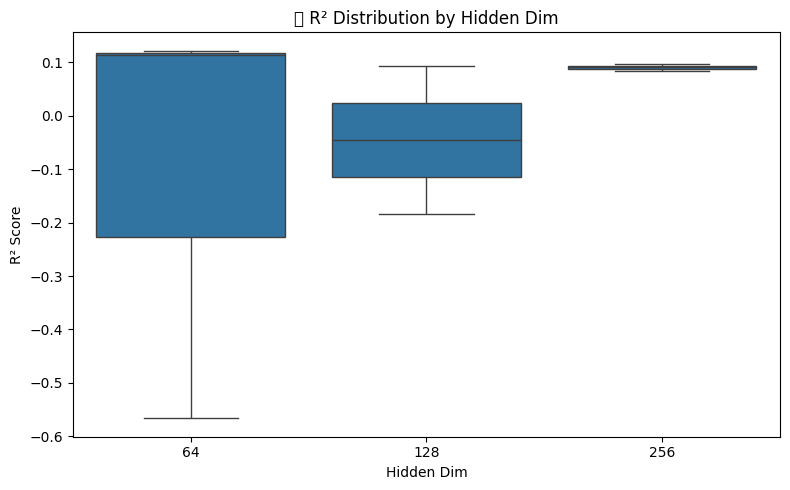

/tmp/ipykernel_27605/1365461160.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


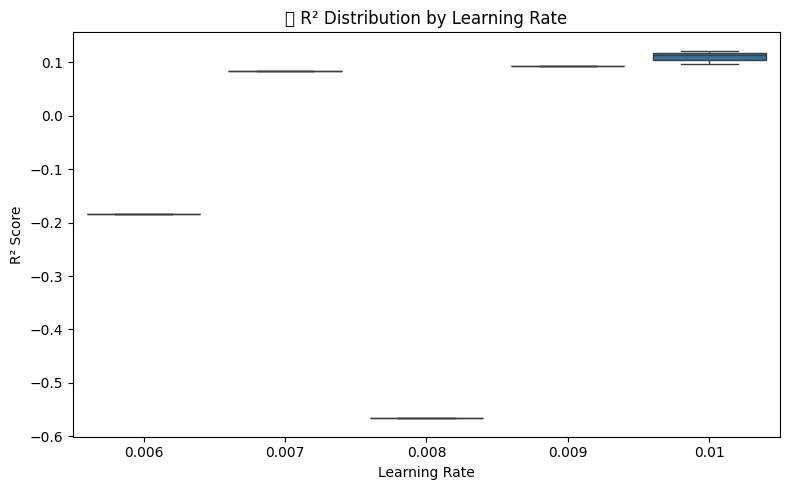

/tmp/ipykernel_27605/1365461160.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


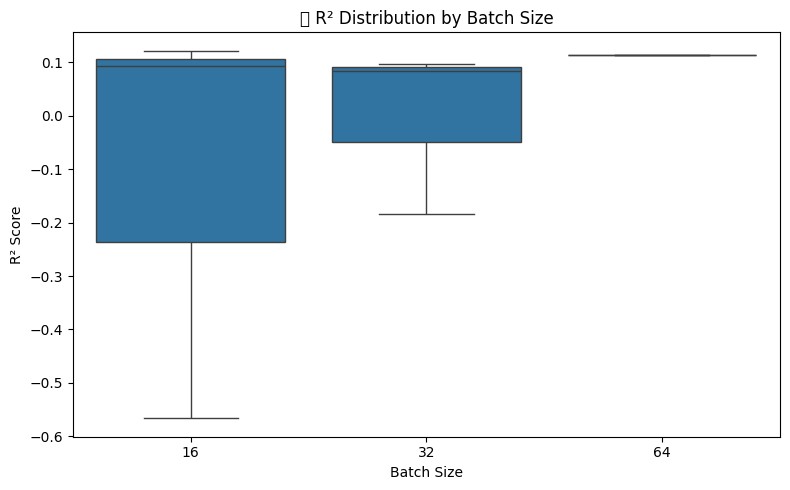

/tmp/ipykernel_27605/1365461160.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


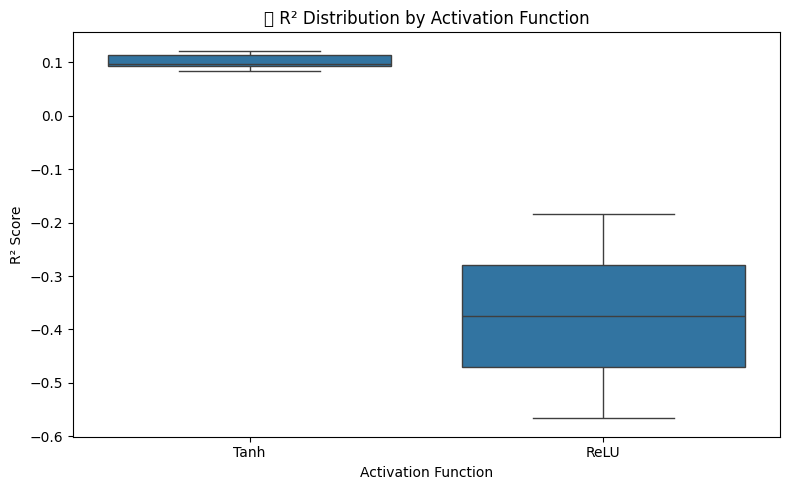

/tmp/ipykernel_27605/1365461160.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


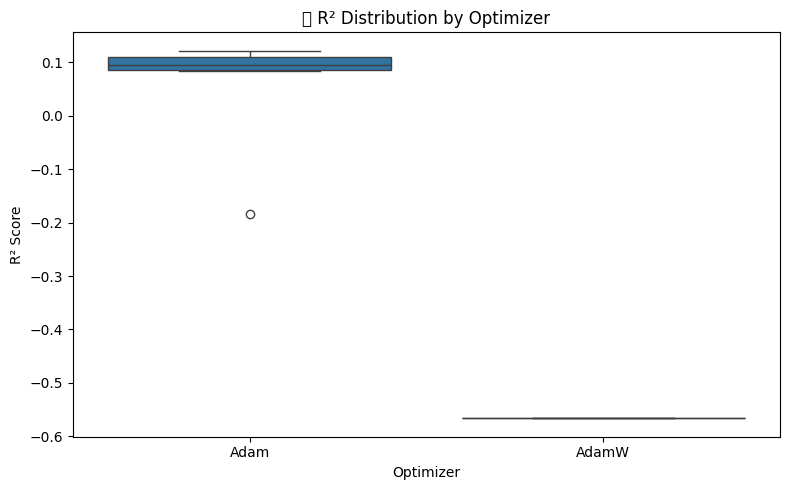


🏆 Best result:
Run ID       : mlp_64h_1e-02lr_16bs_100ep_Tanh_Adam
Hidden Dim   : 64
Learning Rate: 0.01000
Batch Size   : 16
activation_fn  : Tanh
optimizer_name: Adam
R²           : 0.1220
MAE          : 0.0605
MSE          : 0.006078

📌 R² threshold (95% of max): 0.1159
🔍 Found 1 stable candidates:

   hidden_dim    lr  batch_size activation_fn optimizer_name     R2     MAE  \
0          64  0.01          16          Tanh           Adam  0.122  0.0605   

        MSE  
0  0.006078  


In [55]:
# 📁 src/tuning/visualize_search_results.py
# ➞ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📅 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH)

# 📊 Boxplot: R² by Hidden Dim
plt.figure(figsize=(8, 5))
sns.boxplot(x="hidden_dim", y="R2", data=df_log)
plt.title("📈 R² Distribution by Hidden Dim")
plt.xlabel("Hidden Dim")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 📊 Boxplot: R² by Learning Rate
plt.figure(figsize=(8, 5))
sns.boxplot(x="lr", y="R2", data=df_log)
plt.title("📈 R² Distribution by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 📊 Boxplot: R² by Batch Size
plt.figure(figsize=(8, 5))
sns.boxplot(x="batch_size", y="R2", data=df_log)
plt.title("📈 R² Distribution by Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 📊 Boxplot: R² by Activation Function
plt.figure(figsize=(8, 5))
sns.boxplot(x="activation_fn", y="R2", data=df_log)
plt.title("📈 R² Distribution by Activation Function")
plt.xlabel("Activation Function")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 📊 Boxplot: R² by Optimizer
plt.figure(figsize=(8, 5))
sns.boxplot(x="optimizer_name", y="R2", data=df_log)
plt.title("📈 R² Distribution by Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 🏆 Show best configuration
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\n🏆 Best result:")
print(f"Run ID       : {best_row['run_id']}")
print(f"Hidden Dim   : {int(best_row['hidden_dim'])}")
print(f"Learning Rate: {best_row['lr']:.5f}")
print(f"Batch Size   : {int(best_row['batch_size'])}")
print(f"activation_fn  : {best_row['activation_fn']}")
print(f"optimizer_name: {best_row['optimizer_name']}")
print(f"R²           : {best_row['R2']:.4f}")
print(f"MAE          : {best_row['MAE']:.4f}")
print(f"MSE          : {best_row['MSE']:.6f}")

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n📌 R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "batch_size", "activation_fn", "optimizer_name", "R2", "MAE", "MSE"]])
